In [1]:
import os
import sys
sys.path.append('/kaggle/input/timm-0-6-9/pytorch-image-models-master')
import glob
import numpy as np
import pandas as pd
import random
import math
import gc
import cv2
from tqdm import tqdm
import time
from functools import lru_cache
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef

In [2]:
CFG = {
    'seed': 42,
    'model': 'resnet50',
    'img_size': 256,
    'epochs': 10,
    'train_bs': 100, 
    'valid_bs': 64,
    'lr': 1e-3, 
    'weight_decay': 1e-6,
    'num_workers': 2
}

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CFG['seed'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def expand_contact_id(df):
    """
    Splits out contact_id into seperate columns.
    """
    df["game_play"] = df["contact_id"].str[:12]
    df["step"] = df["contact_id"].str.split("_").str[-3].astype("int")
    df["nfl_player_id_1"] = df["contact_id"].str.split("_").str[-2]
    df["nfl_player_id_2"] = df["contact_id"].str.split("_").str[-1]
    return df

labels = expand_contact_id(pd.read_csv("/kaggle/input/nfl-player-contact-detection/sample_submission.csv"))

test_tracking = pd.read_csv("/kaggle/input/nfl-player-contact-detection/test_player_tracking.csv")

test_helmets = pd.read_csv("/kaggle/input/nfl-player-contact-detection/test_baseline_helmets.csv")

test_video_metadata = pd.read_csv("/kaggle/input/nfl-player-contact-detection/test_video_metadata.csv")

In [5]:
!mkdir -p ../work/frames

for video in tqdm(test_helmets.video.unique()):
    if 'Endzone2' not in video:
        !ffmpeg -i /kaggle/input/nfl-player-contact-detection/test/{video} -q:v 2 -f image2 /kaggle/work/frames/{video}_%04d.jpg -hide_banner -loglevel error

100%|██████████| 4/4 [00:46<00:00, 11.58s/it]


In [6]:
def create_features(df, tr_tracking, merge_col="step", use_cols=["x_position", "y_position"]):
    output_cols = []
    df_combo = (
        df.astype({"nfl_player_id_1": "str"})
        .merge(
            tr_tracking.astype({"nfl_player_id": "str"})[
                ["game_play", merge_col, "nfl_player_id",] + use_cols
            ],
            left_on=["game_play", merge_col, "nfl_player_id_1"],
            right_on=["game_play", merge_col, "nfl_player_id"],
            how="left",
        )
        .rename(columns={c: c+"_1" for c in use_cols})
        .drop("nfl_player_id", axis=1)
        .merge(
            tr_tracking.astype({"nfl_player_id": "str"})[
                ["game_play", merge_col, "nfl_player_id"] + use_cols
            ],
            left_on=["game_play", merge_col, "nfl_player_id_2"],
            right_on=["game_play", merge_col, "nfl_player_id"],
            how="left",
        )
        .drop("nfl_player_id", axis=1)
        .rename(columns={c: c+"_2" for c in use_cols})
        .sort_values(["game_play", merge_col, "nfl_player_id_1", "nfl_player_id_2"])
        .reset_index(drop=True)
    )
    output_cols += [c+"_1" for c in use_cols]
    output_cols += [c+"_2" for c in use_cols]
    
    if ("x_position" in use_cols) & ("y_position" in use_cols):
        index = df_combo['x_position_2'].notnull()
        
        distance_arr = np.full(len(index), np.nan)
        tmp_distance_arr = np.sqrt(
            np.square(df_combo.loc[index, "x_position_1"] - df_combo.loc[index, "x_position_2"])
            + np.square(df_combo.loc[index, "y_position_1"]- df_combo.loc[index, "y_position_2"])
        )
        
        distance_arr[index] = tmp_distance_arr
        df_combo['distance'] = distance_arr
        output_cols += ["distance"]
        
    df_combo['G_flug'] = (df_combo['nfl_player_id_2']=="G")
    output_cols += ["G_flug"]
    return df_combo, output_cols


use_cols = [
    'x_position', 'y_position', 'speed', 'distance',
    'direction', 'orientation', 'acceleration', 'sa'
]

test, feature_cols = create_features(labels, test_tracking, use_cols=use_cols)
test

contact_id  contact     game_play  step  \
0        58168_003392_0_37084_37211        0  58168_003392     0   
1        58168_003392_0_37084_38556        0  58168_003392     0   
2        58168_003392_0_37084_38567        0  58168_003392     0   
3        58168_003392_0_37084_38590        0  58168_003392     0   
4        58168_003392_0_37084_39947        0  58168_003392     0   
...                             ...      ...           ...   ...   
49583  58172_003247_125_52521_52939        0  58172_003247   125   
49584      58172_003247_125_52521_G        0  58172_003247   125   
49585  58172_003247_125_52852_52939        0  58172_003247   125   
49586      58172_003247_125_52852_G        0  58172_003247   125   
49587      58172_003247_125_52939_G        0  58172_003247   125   

      nfl_player_id_1 nfl_player_id_2  x_position_1  y_position_1  speed_1  \
0               37084           37211         41.90         20.08     0.54   
1               37084           38556         41.90         20.08     0.54   
2               37084           38567         41.90         20.08     0.54   
3               37084           38590         41.90         20.08     0.54   
4               37084           39947         41.90         20.08     0.54   
...               ...             ...           ...           ...      ...   
49583           52521           52939         23.44          4.04     1.41   
49584           52521               G         23.44          4.04     1.41   
49585           52852           52939         32.67          2.18     2.34   
49586           52852               G         32.67          2.18     2.34   
49587           52939               G         37.94          2.10     2.29   

       distance_1  ...  x_position_2  y_position_2  speed_2  distance_2  \
0            0.06  ...         39.59         17.07     0.53        0.05   
1            0.06  ...         41.93         30.61     0.67        0.05   
2            0.06  ...         40.37         19.88     0.66        0.07   
3            0.06  ...         40.33         25.28     0.52        0.06   
4            0.06  ...         40.11         26.73     0.99        0.09   
...           ...  ...           ...           ...      ...         ...   
49583        0.15  ...         37.94          2.10     2.29        0.24   
49584        0.15  ...           NaN           NaN      NaN         NaN   
49585        0.24  ...         37.94          2.10     2.29        0.24   
49586        0.24  ...           NaN           NaN      NaN         NaN   
49587        0.24  ...           NaN           NaN      NaN         NaN   

       direction_2  orientation_2  acceleration_2  sa_2   distance  G_flug  
0           134.84          84.73            1.43  1.42   3.794232   False  
1           232.50         227.00            1.82  1.61  10.530043   False  
2           136.70          88.92            0.90  0.89   1.543017   False  
3           141.08         100.37            0.59  0.58   5.431841   False  
4           163.38          90.69            1.68  1.64   6.886697   False  
...            ...            ...             ...   ...        ...     ...  
49583       211.73         215.11            2.43 -2.43  14.629204   False  
49584          NaN            NaN             NaN   NaN        NaN    True  
49585       211.73         215.11            2.43 -2.43   5.270607   False  
49586          NaN            NaN             NaN   NaN        NaN    True  
49587          NaN            NaN             NaN   NaN        NaN    True  

[49588 rows x 24 columns]

In [7]:
test_filtered = test.query('not distance>2').reset_index(drop=True)
test_filtered['frame'] = (test_filtered['step']/10*59.94+5*59.94).astype('int')+1
test_filtered

contact_id  contact     game_play  step nfl_player_id_1  \
0     58168_003392_0_37084_38567        0  58168_003392     0           37084   
1         58168_003392_0_37084_G        0  58168_003392     0           37084   
2     58168_003392_0_37211_46445        0  58168_003392     0           37211   
3         58168_003392_0_37211_G        0  58168_003392     0           37211   
4         58168_003392_0_38556_G        0  58168_003392     0           38556   
...                          ...      ...           ...   ...             ...   
6626    58172_003247_125_48241_G        0  58172_003247   125           48241   
6627    58172_003247_125_48335_G        0  58172_003247   125           48335   
6628    58172_003247_125_52521_G        0  58172_003247   125           52521   
6629    58172_003247_125_52852_G        0  58172_003247   125           52852   
6630    58172_003247_125_52939_G        0  58172_003247   125           52939   

     nfl_player_id_2  x_position_1  y_position_1  speed_1  distance_1  ...  \
0              38567         41.90         20.08     0.54        0.06  ...   
1                  G         41.90         20.08     0.54        0.06  ...   
2              46445         39.59         17.07     0.53        0.05  ...   
3                  G         39.59         17.07     0.53        0.05  ...   
4                  G         41.93         30.61     0.67        0.05  ...   
...              ...           ...           ...      ...         ...  ...   
6626               G         33.86         -1.28     0.79        0.08  ...   
6627               G         44.74          3.16     4.72        0.48  ...   
6628               G         23.44          4.04     1.41        0.15  ...   
6629               G         32.67          2.18     2.34        0.24  ...   
6630               G         37.94          2.10     2.29        0.24  ...   

      y_position_2  speed_2  distance_2  direction_2  orientation_2  \
0            19.88     0.66        0.07       136.70          88.92   
1              NaN      NaN         NaN          NaN            NaN   
2            18.08     1.10        0.10       148.93          92.39   
3              NaN      NaN         NaN          NaN            NaN   
4              NaN      NaN         NaN          NaN            NaN   
...            ...      ...         ...          ...            ...   
6626           NaN      NaN         NaN          NaN            NaN   
6627           NaN      NaN         NaN          NaN            NaN   
6628           NaN      NaN         NaN          NaN            NaN   
6629           NaN      NaN         NaN          NaN            NaN   
6630           NaN      NaN         NaN          NaN            NaN   

      acceleration_2  sa_2  distance  G_flug  frame  
0               0.90  0.89  1.543017   False    300  
1                NaN   NaN       NaN    True    300  
2               2.03  2.03  1.258014   False    300  
3                NaN   NaN       NaN    True    300  
4                NaN   NaN       NaN    True    300  
...              ...   ...       ...     ...    ...  
6626             NaN   NaN       NaN    True   1049  
6627             NaN   NaN       NaN    True   1049  
6628             NaN   NaN       NaN    True   1049  
6629             NaN   NaN       NaN    True   1049  
6630             NaN   NaN       NaN    True   1049  

[6631 rows x 25 columns]

In [8]:
del test, labels, test_tracking
gc.collect()

55

In [9]:
train_aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
    A.Normalize(mean=[0.], std=[1.]),
    ToTensorV2()
])

valid_aug = A.Compose([
    A.Normalize(mean=[0.], std=[1.]),
    ToTensorV2()
])

In [10]:
video2helmets = {}
test_helmets_new = test_helmets.set_index('video')
for video in tqdm(test_helmets.video.unique()):
    video2helmets[video] = test_helmets_new.loc[video].reset_index(drop=True)
    
del test_helmets, test_helmets_new
gc.collect()

100%|██████████| 4/4 [00:00<00:00, 233.55it/s]


23

In [11]:
video2frames = {}

for game_play in tqdm(test_video_metadata.game_play.unique()):
    for view in ['Endzone', 'Sideline']:
        video = game_play + f'_{view}.mp4'
        video2frames[video] = max(list(map(lambda x:int(x.split('_')[-1].split('.')[0]), \
                                           glob.glob(f'/kaggle/work/frames/{video}*'))))

100%|██████████| 2/2 [00:00<00:00, 44.34it/s]


In [12]:
class MyDataset(Dataset):
    def __init__(self, df, aug=valid_aug, mode='train'):
        self.df = df
        self.frame = df.frame.values
        self.feature = df[feature_cols].fillna(-1).values
        self.players = df[['nfl_player_id_1','nfl_player_id_2']].values
        self.game_play = df.game_play.values
        self.aug = aug
        self.mode = mode
        
    def __len__(self):
        return len(self.df)
    
    # @lru_cache(1024)
    # def read_img(self, path):
    #     return cv2.imread(path, 0)
   
    def __getitem__(self, idx):   
        window = 24
        frame = self.frame[idx]
        
        if self.mode == 'train':
            frame = frame + random.randint(-6, 6)

        players = []
        for p in self.players[idx]:
            if p == 'G':
                players.append(p)
            else:
                players.append(int(p))
        
        imgs = []
        for view in ['Endzone', 'Sideline']:
            video = self.game_play[idx] + f'_{view}.mp4'

            tmp = video2helmets[video]
#             tmp = tmp.query('@frame-@window<=frame<=@frame+@window')
            tmp[tmp['frame'].between(frame-window, frame+window)]
            tmp = tmp[tmp.nfl_player_id.isin(players)]#.sort_values(['nfl_player_id', 'frame'])
            tmp_frames = tmp.frame.values
            tmp = tmp.groupby('frame')[['left','width','top','height']].mean()
#0.002s

            bboxes = []
            for f in range(frame-window, frame+window+1, 1):
                if f in tmp_frames:
                    x, w, y, h = tmp.loc[f][['left','width','top','height']]
                    bboxes.append([x, w, y, h])
                else:
                    bboxes.append([np.nan, np.nan, np.nan, np.nan])
            bboxes = pd.DataFrame(bboxes).interpolate(limit_direction='both').values
            bboxes = bboxes[::4]

            if bboxes.sum() > 0:
                flag = 1
            else:
                flag = 0
#0.03s
                    
            for i, f in enumerate(range(frame-window, frame+window+1, 4)):
                img_new = np.zeros((256, 256), dtype=np.float32)

                if flag == 1 and f <= video2frames[video]:
                    img = cv2.imread(f'/kaggle/work/frames/{video}_{f:04d}.jpg', 0)

                    x, w, y, h = bboxes[i]

                    img = img[int(y+h/2)-128:int(y+h/2)+128,int(x+w/2)-128:int(x+w/2)+128].copy()
                    img_new[:img.shape[0], :img.shape[1]] = img
                    
                imgs.append(img_new)
#0.06s
                
        feature = np.float32(self.feature[idx])

        img = np.array(imgs).transpose(1, 2, 0)    
        img = self.aug(image=img)["image"]
        label = np.float32(self.df.contact.values[idx])

        return img, feature, label

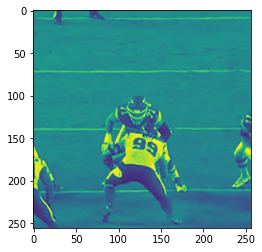

(torch.Size([26, 256, 256]),
 array([4.1900002e+01, 2.0080000e+01, 5.4000002e-01, 5.9999999e-02,
        2.5269000e+02, 2.6231000e+02, 9.2000002e-01, 8.9999998e-01,
        4.0369999e+01, 1.9879999e+01, 6.6000003e-01, 7.0000000e-02,
        1.3670000e+02, 8.8919998e+01, 8.9999998e-01, 8.8999999e-01,
        1.5430166e+00, 0.0000000e+00], dtype=float32),
 0.0)

In [13]:
img, feature, label = MyDataset(test_filtered, valid_aug, 'test')[0]
plt.imshow(img.permute(1,2,0)[:,:,7])
plt.show()
img.shape, feature, label

In [14]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.backbone = timm.create_model(CFG['model'], pretrained=False, num_classes=500, in_chans=13)
        self.mlp = nn.Sequential(
            nn.Linear(18, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            # nn.Linear(64, 64),
            # nn.LayerNorm(64),
            # nn.ReLU(),
            # nn.Dropout(0.2)
        )
        self.fc = nn.Linear(64+500*2, 1)

    def forward(self, img, feature):
        b, c, h, w = img.shape
        img = img.reshape(b*2, c//2, h, w)
        img = self.backbone(img).reshape(b, -1)
        feature = self.mlp(feature)
        y = self.fc(torch.cat([img, feature], dim=1))
        return y

In [15]:
test_set = MyDataset(test_filtered, valid_aug, 'test')
test_loader = DataLoader(test_set, batch_size=CFG['valid_bs'], shuffle=False, num_workers=CFG['num_workers'], pin_memory=True)

model = Model().to(device)
model.load_state_dict(torch.load('/kaggle/input/nfl-exp1/resnet50_fold0.pt'))

model.eval()
    
y_pred = []
with torch.no_grad():
    tk = tqdm(test_loader, total=len(test_loader))
    for step, batch in enumerate(tk):
        if(step % 4 != 3):
            img, feature, label = [x.to(device) for x in batch]
            output1 = model(img, feature).squeeze(-1)
            output2 = model(img.flip(-1), feature).squeeze(-1)
            
            y_pred.extend(0.2*(output1.sigmoid().cpu().numpy()) + 0.8*(output2.sigmoid().cpu().numpy()))
        else:
            img, feature, label = [x.to(device) for x in batch]
            output = model(img.flip(-1), feature).squeeze(-1)
            y_pred.extend(output.sigmoid().cpu().numpy())    

y_pred = np.array(y_pred)

100%|██████████| 104/104 [17:01<00:00,  9.82s/it]


In [16]:
# y_pred

array([0.00411539, 0.00973676, 0.00100008, ..., 0.01578115, 0.01929891,
       0.01299736], dtype=float32)

In [18]:
# len(y_pred)

6631

In [20]:
# y_pred_sum = np.sum(y_pred)
# y_pred_sum

859.3241

In [16]:
# th = 0.29

# test_filtered['contact'] = (y_pred >= th).astype('int')
test_filtered['contact'] = y_pred

sub = pd.read_csv('/kaggle/input/nfl-player-contact-detection/sample_submission.csv')

sub = sub.drop("contact", axis=1).merge(test_filtered[['contact_id', 'contact']], how='left', on='contact_id')
# sub['contact'] = sub['contact'].fillna(0).astype('int')
sub['contact'] = sub['contact'].fillna(0)

sub[["contact_id", "contact"]].to_csv("submission_cnn.csv", index=False)

sub.head()

contact_id  contact
0  58168_003392_0_38590_43854      0.0
1  58168_003392_0_38590_41257      0.0
2  58168_003392_0_38590_41944      0.0
3  58168_003392_0_38590_42386      0.0
4  58168_003392_0_38590_47944      0.0

In [17]:
%whos

Variable              Type                Data/Info
---------------------------------------------------
A                     module              <module 'albumentations' <...>umentations/__init__.py'>
CFG                   dict                n=9
DataLoader            type                <class 'torch.utils.data.dataloader.DataLoader'>
Dataset               type                <class 'torch.utils.data.dataset.Dataset'>
F                     module              <module 'torch.nn.functio<...>/torch/nn/functional.py'>
GradScaler            type                <class 'torch.cuda.amp.grad_scaler.GradScaler'>
Model                 type                <class '__main__.Model'>
MyDataset             type                <class '__main__.MyDataset'>
ToTensorV2            SerializableMeta    <class 'albumentations.py<...>h.transforms.ToTensorV2'>
autocast              type                <class 'torch.cuda.amp.autocast_mode.autocast'>
batch                 list                n=3
create_features 

In [20]:
# 현재 메모리에 할당된 변수/객체 제거
del CFG, Model, MyDataset, batch, create_features, device, expand_contact_id, feature, feature_cols, game_play, img, label, model, output, output1, output2, seed_everything, step, sub, test_filtered, test_loader, test_set, test_video_metadata, tk, train_aug, use_cols, valid_aug, video, video2frames, video2helmets, view, y_pred 

# 가비지 컬렉터 수동 호출
gc.collect()

48

In [21]:
%whos

Variable            Type                Data/Info
-------------------------------------------------
A                   module              <module 'albumentations' <...>umentations/__init__.py'>
DataLoader          type                <class 'torch.utils.data.dataloader.DataLoader'>
Dataset             type                <class 'torch.utils.data.dataset.Dataset'>
F                   module              <module 'torch.nn.functio<...>/torch/nn/functional.py'>
GradScaler          type                <class 'torch.cuda.amp.grad_scaler.GradScaler'>
ToTensorV2          SerializableMeta    <class 'albumentations.py<...>h.transforms.ToTensorV2'>
autocast            type                <class 'torch.cuda.amp.autocast_mode.autocast'>
cv2                 module              <module 'cv2' from '/opt/<...>ackages/cv2/__init__.py'>
gc                  module              <module 'gc' (built-in)>
glob                module              <module 'glob' from '/opt<...>a/lib/python3.7/glob.py'>
lru_cac

In [22]:
import os
import torch

class Config:
    AUTHOR = "colum2131"

    NAME = "NFLC-" + "Exp001-simple-xgb-baseline"

    COMPETITION = "nfl-player-contact-detection"

    seed = 42
    num_fold = 5
    
    xgb_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'learning_rate':0.03,
        'tree_method':'hist' if not torch.cuda.is_available() else 'gpu_hist'
    }

In [23]:
import os
import gc
import subprocess

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import Video, display

from scipy.optimize import minimize
import cv2
from glob import glob
from tqdm import tqdm

from sklearn.model_selection import GroupKFold
from sklearn.metrics import (
    roc_auc_score,
    matthews_corrcoef,
)

import xgboost as xgb

import torch

if torch.cuda.is_available():
    import cupy 
    import cudf
    from cuml import ForestInference

In [24]:
def setup(cfg):
    cfg.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # set dirs
    cfg.INPUT = f'../input/{cfg.COMPETITION}'
    cfg.EXP = cfg.NAME
    cfg.OUTPUT_EXP = cfg.NAME
    cfg.SUBMISSION = './'
    cfg.DATASET = '../input/'

    cfg.EXP_MODEL = os.path.join(cfg.EXP, 'model')
    cfg.EXP_FIG = os.path.join(cfg.EXP, 'fig')
    cfg.EXP_PREDS = os.path.join(cfg.EXP, 'preds')

    # make dirs
    for d in [cfg.EXP_MODEL, cfg.EXP_FIG, cfg.EXP_PREDS]:
        os.makedirs(d, exist_ok=True)
        
    return cfg

In [25]:
# ==============================
# function
# ==============================
# ref: https://www.kaggle.com/code/robikscube/nfl-player-contact-detection-getting-started
def add_contact_id(df):
    # Create contact ids
    df["contact_id"] = (
        df["game_play"]
        + "_"
        + df["step"].astype("str")
        + "_"
        + df["nfl_player_id_1"].astype("str")
        + "_"
        + df["nfl_player_id_2"].astype("str")
    )
    return df

def expand_contact_id(df):
    """
    Splits out contact_id into seperate columns.
    """
    df["game_play"] = df["contact_id"].str[:12]
    df["step"] = df["contact_id"].str.split("_").str[-3].astype("int")
    df["nfl_player_id_1"] = df["contact_id"].str.split("_").str[-2]
    df["nfl_player_id_2"] = df["contact_id"].str.split("_").str[-1]
    return df

# cross validation
def get_groupkfold(train, target_col, group_col, n_splits):
    kf = GroupKFold(n_splits=n_splits)
    generator = kf.split(train, train[target_col], train[group_col])
    fold_series = []
    for fold, (idx_train, idx_valid) in enumerate(generator):
        fold_series.append(pd.Series(fold, index=idx_valid))
    fold_series = pd.concat(fold_series).sort_index()
    return fold_series

# xgboost code
def fit_xgboost(cfg, X, y, params, add_suffix=''):
    """
    xgb_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'learning_rate':0.01,
        'tree_method':'gpu_hist'
    }
    """
    oof_pred = np.zeros(len(y), dtype=np.float32)
    for fold in sorted(cfg.folds.unique()):
        if fold == -1: continue
        idx_train = (cfg.folds!=fold)
        idx_valid = (cfg.folds==fold)
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]
        display(pd.Series(y_valid).value_counts())

        xgb_train = xgb.DMatrix(x_train, label=y_train)
        xgb_valid = xgb.DMatrix(x_valid, label=y_valid)
        evals = [(xgb_train,'train'),(xgb_valid,'eval')]

        model = xgb.train(
            params,
            xgb_train,
            num_boost_round=10_000,
            early_stopping_rounds=100,
            evals=evals,
            verbose_eval=100,
        )

        model_path = os.path.join(cfg.EXP_MODEL, f'xgb_fold{fold}{add_suffix}.model')
        model.save_model(model_path)
        if not torch.cuda.is_available():
            model = xgb.Booster().load_model(model_path)
        else:
            model = ForestInference.load(model_path, output_class=True, model_type='xgboost')
        pred_i = model.predict_proba(x_valid)[:, 1]
        oof_pred[x_valid.index] = pred_i
        score = round(roc_auc_score(y_valid, pred_i), 5)
        print(f'Performance of the prediction: {score}\n')
        del model; gc.collect()

    np.save(os.path.join(cfg.EXP_PREDS, f'oof_pred{add_suffix}'), oof_pred)
    score = round(roc_auc_score(y, oof_pred), 5)
    print(f'All Performance of the prediction: {score}')
    return oof_pred

def pred_xgboost(X, data_dir, add_suffix=''):
    models = glob(os.path.join(data_dir, f'xgb_fold*{add_suffix}.model'))
    if not torch.cuda.is_available():
         models = [xgb.Booster().load_model(model_path) for model in models]
    else:
        models = [ForestInference.load(model, output_class=True, model_type='xgboost') for model in models]
    preds = np.array([model.predict_proba(X)[:, 1] for model in models])
    preds = np.mean(preds, axis=0)
    return preds

In [27]:
# ==============================
# read data
# ==============================
cfg = setup(Config)

if not torch.cuda.is_available():
    tr_tracking = pd.read_csv(os.path.join(cfg.INPUT, 'train_player_tracking.csv'), parse_dates=["datetime"])
    te_tracking = pd.read_csv(os.path.join(cfg.INPUT, 'test_player_tracking.csv'), parse_dates=["datetime"])
    # tr_helmets = pd.read_csv(os.path.join(cfg.INPUT, 'train_baseline_helmets.csv'))
    # te_helmets = pd.read_csv(os.path.join(cfg.INPUT, 'test_baseline_helmets.csv'))
    # tr_video_metadata = pd.read_csv(os.path.join(cfg.INPUT, 'train_video_metadata.csv'))
    # te_video_metadata = pd.read_csv(os.path.join(cfg.INPUT, 'test_video_metadata.csv'))
    sub = pd.read_csv(os.path.join(cfg.INPUT, 'sample_submission.csv'))

    train = pd.read_csv(os.path.join(cfg.INPUT, 'train_labels.csv'), parse_dates=["datetime"])
    test = expand_contact_id(sub)
    
else:
    tr_tracking = cudf.read_csv(os.path.join(cfg.INPUT, 'train_player_tracking.csv'), parse_dates=["datetime"])
    te_tracking = cudf.read_csv(os.path.join(cfg.INPUT, 'test_player_tracking.csv'), parse_dates=["datetime"])
    # tr_helmets = cudf.read_csv(os.path.join(cfg.INPUT, 'train_baseline_helmets.csv'))
    # te_helmets = cudf.read_csv(os.path.join(cfg.INPUT, 'test_baseline_helmets.csv'))
    # tr_video_metadata = cudf.read_csv(os.path.join(cfg.INPUT, 'train_video_metadata.csv'))
    # te_video_metadata = cudf.read_csv(os.path.join(cfg.INPUT, 'test_video_metadata.csv'))
    sub = pd.read_csv(os.path.join(cfg.INPUT, 'sample_submission.csv'))

    train = cudf.read_csv(os.path.join(cfg.INPUT, 'train_labels.csv'), parse_dates=["datetime"])
    test = cudf.DataFrame(expand_contact_id(sub))

In [28]:
# ==============================
# feature engineering
# ==============================
def create_features(df, tr_tracking, merge_col="step", use_cols=["x_position", "y_position"]):
    output_cols = []
    df_combo = (
        df.astype({"nfl_player_id_1": "str"})
        .merge(
            tr_tracking.astype({"nfl_player_id": "str"})[
                ["game_play", merge_col, "nfl_player_id",] + use_cols
            ],
            left_on=["game_play", merge_col, "nfl_player_id_1"],
            right_on=["game_play", merge_col, "nfl_player_id"],
            how="left",
        )
        .rename(columns={c: c+"_1" for c in use_cols})
        .drop("nfl_player_id", axis=1)
        .merge(
            tr_tracking.astype({"nfl_player_id": "str"})[
                ["game_play", merge_col, "nfl_player_id"] + use_cols
            ],
            left_on=["game_play", merge_col, "nfl_player_id_2"],
            right_on=["game_play", merge_col, "nfl_player_id"],
            how="left",
        )
        .drop("nfl_player_id", axis=1)
        .rename(columns={c: c+"_2" for c in use_cols})
        .sort_values(["game_play", merge_col, "nfl_player_id_1", "nfl_player_id_2"])
        .reset_index(drop=True)
    )
    output_cols += [c+"_1" for c in use_cols]
    output_cols += [c+"_2" for c in use_cols]
    
    if ("x_position" in use_cols) & ("y_position" in use_cols):
        index = df_combo['x_position_2'].notnull()
        if torch.cuda.is_available():
            index = index.to_array()
        distance_arr = np.full(len(index), np.nan)
        tmp_distance_arr = np.sqrt(
            np.square(df_combo.loc[index, "x_position_1"] - df_combo.loc[index, "x_position_2"])
            + np.square(df_combo.loc[index, "y_position_1"]- df_combo.loc[index, "y_position_2"])
        )
        if torch.cuda.is_available():
            tmp_distance_arr = tmp_distance_arr.to_array()
        distance_arr[index] = tmp_distance_arr
        df_combo['distance'] = distance_arr
        output_cols += ["distance"]
        
    df_combo['G_flug'] = (df_combo['nfl_player_id_2']=="G")
    output_cols += ["G_flug"]
    return df_combo, output_cols


use_cols = [
    'x_position', 'y_position', 'speed', 'distance',
    'direction', 'orientation', 'acceleration', 'sa'
]
train, feature_cols = create_features(train, tr_tracking, use_cols=use_cols)
test, feature_cols = create_features(test, te_tracking, use_cols=use_cols)
if torch.cuda.is_available():
    train = train.to_pandas()
    test = test.to_pandas()

display(train)

contact_id     game_play                datetime  \
0         58168_003392_0_37084_37211  58168_003392 2020-09-11 03:01:48.100   
1         58168_003392_0_37084_38556  58168_003392 2020-09-11 03:01:48.100   
2         58168_003392_0_37084_38567  58168_003392 2020-09-11 03:01:48.100   
3         58168_003392_0_37084_38590  58168_003392 2020-09-11 03:01:48.100   
4         58168_003392_0_37084_39947  58168_003392 2020-09-11 03:01:48.100   
...                              ...           ...                     ...   
4721613  58582_003121_91_52500_52619  58582_003121 2021-10-12 02:42:29.100   
4721614      58582_003121_91_52500_G  58582_003121 2021-10-12 02:42:29.100   
4721615  58582_003121_91_52609_52619  58582_003121 2021-10-12 02:42:29.100   
4721616      58582_003121_91_52609_G  58582_003121 2021-10-12 02:42:29.100   
4721617      58582_003121_91_52619_G  58582_003121 2021-10-12 02:42:29.100   

         step nfl_player_id_1 nfl_player_id_2  contact  x_position_1  \
0           0           37084           37211        0         41.90   
1           0           37084           38556        0         41.90   
2           0           37084           38567        0         41.90   
3           0           37084           38590        0         41.90   
4           0           37084           39947        0         41.90   
...       ...             ...             ...      ...           ...   
4721613    91           52500           52619        0         58.74   
4721614    91           52500               G        0         58.74   
4721615    91           52609           52619        0         60.32   
4721616    91           52609               G        0         60.32   
4721617    91           52619               G        0         58.90   

         y_position_1  speed_1  ...  x_position_2  y_position_2  speed_2  \
0               20.08     0.54  ...         39.59         17.07     0.53   
1               20.08     0.54  ...         41.93         30.61     0.67   
2               20.08     0.54  ...         40.37         19.88     0.66   
3               20.08     0.54  ...         40.33         25.28     0.52   
4               20.08     0.54  ...         40.11         26.73     0.99   
...               ...      ...  ...           ...           ...      ...   
4721613         40.11     1.34  ...         58.90         22.09     1.32   
4721614         40.11     1.34  ...           NaN           NaN      NaN   
4721615         25.93     1.38  ...         58.90         22.09     1.32   
4721616         25.93     1.38  ...           NaN           NaN      NaN   
4721617         22.09     1.32  ...           NaN           NaN      NaN   

         distance_2  direction_2  orientation_2  acceleration_2  sa_2  \
0              0.05       134.84          84.73            1.43  1.42   
1              0.05       232.50         227.00            1.82  1.61   
2              0.07       136.70          88.92            0.90  0.89   
3              0.06       141.08         100.37            0.59  0.58   
4              0.09       163.38          90.69            1.68  1.64   
...             ...          ...            ...             ...   ...   
4721613        0.14        74.21          47.63            0.96 -0.44   
4721614         NaN          NaN            NaN             NaN   NaN   
4721615        0.14        74.21          47.63            0.96 -0.44   
4721616         NaN          NaN            NaN             NaN   NaN   
4721617         NaN          NaN            NaN             NaN   NaN   

          distance  G_flug  
0         3.794232   False  
1        10.530043   False  
2         1.543017   False  
3         5.431841   False  
4         6.886697   False  
...            ...     ...  
4721613  18.020710   False  
4721614        NaN    True  
4721615   4.094142   False  
4721616        NaN    True  
4721617        NaN    True  

[4721618 rows x 25 columns]

In [29]:
DISTANCE_THRESH = 2

train_y = train['contact'].values
oof_pred = np.zeros(len(train))
cond_dis_train = (train['distance']<=DISTANCE_THRESH) | (train['distance'].isna())
cond_dis_test = (test['distance']<=DISTANCE_THRESH) | (test['distance'].isna())

train = train[cond_dis_train]
train.reset_index(inplace = True, drop = True)

print('number of train data : ',len(train))

_ = gc.collect()

number of train data :  660560


In [30]:
CLUSTERS = [10, 50, 100, 500]

def add_step_pct(df, cluster):
    df['step_pct'] = cluster * (df['step']-min(df['step']))/(max(df['step'])-min(df['step']))
    df['step_pct'] = df['step_pct'].apply(np.ceil).astype(np.int32)
    return df

for cluster in CLUSTERS:
    train = train.groupby('game_play').apply(lambda x:add_step_pct(x,cluster))
    test = test.groupby('game_play').apply(lambda x:add_step_pct(x,cluster))

    for helmet_view in ['Sideline', 'Endzone']:
        helmet_train = pd.read_csv('/kaggle/input/nfl-player-contact-detection/train_baseline_helmets.csv')
        helmet_train.loc[helmet_train['view']=='Endzone2','view'] = 'Endzone'
        helmet_test = pd.read_csv('/kaggle/input/nfl-player-contact-detection/test_baseline_helmets.csv')
        helmet_test.loc[helmet_test['view']=='Endzone2','view'] = 'Endzone'

        helmet_train.rename(columns = {'frame': 'step'}, inplace = True)
        helmet_train = helmet_train.groupby('game_play').apply(lambda x:add_step_pct(x,cluster))
        helmet_test.rename(columns = {'frame': 'step'}, inplace = True)
        helmet_test = helmet_test.groupby('game_play').apply(lambda x:add_step_pct(x,cluster))
        helmet_train = helmet_train[helmet_train['view']==helmet_view]
        helmet_test = helmet_test[helmet_test['view']==helmet_view]

        helmet_train['helmet_id'] = helmet_train['game_play'] + '_' + helmet_train['nfl_player_id'].astype(str) + '_' + helmet_train['step_pct'].astype(str)
        helmet_test['helmet_id'] = helmet_test['game_play'] + '_' + helmet_test['nfl_player_id'].astype(str) + '_' + helmet_test['step_pct'].astype(str)

        helmet_train = helmet_train[['helmet_id', 'left', 'width', 'top', 'height']].groupby('helmet_id').mean().reset_index()
        helmet_test = helmet_test[['helmet_id', 'left', 'width', 'top', 'height']].groupby('helmet_id').mean().reset_index()
        for player_ind in [1, 2]:
            train['helmet_id'] = train['game_play'] + '_' + train['nfl_player_id_'+str(player_ind)].astype(str) + \
                                    '_' + train['step_pct'].astype(str)
            test['helmet_id'] = test['game_play'] + '_' + test['nfl_player_id_'+str(player_ind)].astype(str) + \
                                    '_' + test['step_pct'].astype(str)

            train = train.merge(helmet_train, how = 'left')
            test = test.merge(helmet_test, how = 'left')

            train.rename(columns = {i:i+'_'+helmet_view+'_'+str(cluster)+'_'+str(player_ind) for i in ['left', 'width', 'top', 'height']}, inplace = True)
            test.rename(columns = {i:i+'_'+helmet_view+'_'+str(cluster)+'_'+str(player_ind) for i in ['left', 'width', 'top', 'height']}, inplace = True)

            del train['helmet_id'], test['helmet_id']
            gc.collect()

            feature_cols += [i+'_'+helmet_view+'_'+str(cluster)+'_'+str(player_ind) for i in ['left', 'width', 'top', 'height']]
        del helmet_train, helmet_test
        gc.collect()

In [31]:
for cluster in CLUSTERS:
    for helmet_view in ['Sideline', 'Endzone']:
        train.loc[train['G_flug']==True,'left_'+helmet_view+'_'+str(cluster)+'_2'] = train.loc[train['G_flug']==True,'left_'+helmet_view+'_'+str(cluster)+'_1']
        train.loc[train['G_flug']==True,'top_'+helmet_view+'_'+str(cluster)+'_2'] = train.loc[train['G_flug']==True,'top_'+helmet_view+'_'+str(cluster)+'_1']
        train.loc[train['G_flug']==True,'width_'+helmet_view+'_'+str(cluster)+'_2'] = 0
        train.loc[train['G_flug']==True,'height_'+helmet_view+'_'+str(cluster)+'_2'] = 0
        
        test.loc[test['G_flug']==True,'left_'+helmet_view+'_'+str(cluster)+'_2'] = test.loc[test['G_flug']==True,'left_'+helmet_view+'_'+str(cluster)+'_1']
        test.loc[test['G_flug']==True,'top_'+helmet_view+'_'+str(cluster)+'_2'] = test.loc[test['G_flug']==True,'top_'+helmet_view+'_'+str(cluster)+'_1']
        test.loc[test['G_flug']==True,'width_'+helmet_view+'_'+str(cluster)+'_2'] = 0
        test.loc[test['G_flug']==True,'height_'+helmet_view+'_'+str(cluster)+'_2'] = 0

In [32]:
cols = [i[:-2] for i in train.columns if i[-2:]=='_1' and i!='nfl_player_id_1']
train[[i+'_diff' for i in cols]] = np.abs(train[[i+'_1' for i in cols]].values - train[[i+'_2' for i in cols]].values)
test[[i+'_diff' for i in cols]] = np.abs(test[[i+'_1' for i in cols]].values - test[[i+'_2' for i in cols]].values)
feature_cols += [i+'_diff' for i in cols]

cols = ['x_position', 'y_position', 'speed', 'distance', 'direction', 'orientation', 'acceleration', 'sa']
train[[i+'_prod' for i in cols]] = train[[i+'_1' for i in cols]].values * train[[i+'_2' for i in cols]].values
test[[i+'_prod' for i in cols]] = test[[i+'_1' for i in cols]].values * test[[i+'_2' for i in cols]].values
feature_cols += [i+'_prod' for i in cols]

print('number of features : ',len(feature_cols))
print('number of train data : ',len(train))

number of features :  130
number of train data :  660560


In [33]:
# ==============================
# training & inference
# ==============================

cfg.folds = get_groupkfold(train, 'contact', 'game_play', cfg.num_fold)
cfg.folds.to_csv(os.path.join(cfg.EXP_PREDS, 'folds.csv'), index=False)

oof_pred[np.where(cond_dis_train)] = fit_xgboost(cfg, train[feature_cols], train['contact'], 
                                              cfg.xgb_params, add_suffix="_xgb_1st")
np.save('oof_pred.npy',oof_pred)
sub_pred = pred_xgboost(test.loc[cond_dis_test, feature_cols], cfg.EXP_MODEL, add_suffix="_xgb_1st")

0    119036
1     13030
Name: contact, dtype: int64

[0]	train-auc:0.90405	eval-auc:0.90469
[100]	train-auc:0.94383	eval-auc:0.94051
[200]	train-auc:0.95816	eval-auc:0.94846
[300]	train-auc:0.96509	eval-auc:0.95135
[400]	train-auc:0.96982	eval-auc:0.95283
[500]	train-auc:0.97312	eval-auc:0.95355
[600]	train-auc:0.97581	eval-auc:0.95406
[700]	train-auc:0.97811	eval-auc:0.95433
[800]	train-auc:0.98021	eval-auc:0.95445
[900]	train-auc:0.98196	eval-auc:0.95456
[1000]	train-auc:0.98367	eval-auc:0.95484
[1100]	train-auc:0.98522	eval-auc:0.95485
[1200]	train-auc:0.98678	eval-auc:0.95497
[1280]	train-auc:0.98782	eval-auc:0.95494
Performance of the prediction: 0.95495



0    119555
1     12629
Name: contact, dtype: int64

[0]	train-auc:0.90698	eval-auc:0.90237
[100]	train-auc:0.94524	eval-auc:0.93513
[200]	train-auc:0.95916	eval-auc:0.94254
[300]	train-auc:0.96635	eval-auc:0.94429
[400]	train-auc:0.97078	eval-auc:0.94503
[500]	train-auc:0.97433	eval-auc:0.94531
[600]	train-auc:0.97704	eval-auc:0.94559
[700]	train-auc:0.97969	eval-auc:0.94573
[800]	train-auc:0.98170	eval-auc:0.94591
[900]	train-auc:0.98343	eval-auc:0.94594
[958]	train-auc:0.98439	eval-auc:0.94599
Performance of the prediction: 0.94599



0    118545
1     13620
Name: contact, dtype: int64

[0]	train-auc:0.90905	eval-auc:0.89162
[100]	train-auc:0.94630	eval-auc:0.92961
[200]	train-auc:0.96029	eval-auc:0.93896
[300]	train-auc:0.96743	eval-auc:0.94168
[400]	train-auc:0.97172	eval-auc:0.94285
[500]	train-auc:0.97492	eval-auc:0.94321
[600]	train-auc:0.97756	eval-auc:0.94340
[700]	train-auc:0.97999	eval-auc:0.94367
[800]	train-auc:0.98209	eval-auc:0.94365
[821]	train-auc:0.98251	eval-auc:0.94357
Performance of the prediction: 0.94357



0    119615
1     12566
Name: contact, dtype: int64

[0]	train-auc:0.90809	eval-auc:0.89748
[100]	train-auc:0.94664	eval-auc:0.92884
[200]	train-auc:0.96097	eval-auc:0.93529
[300]	train-auc:0.96753	eval-auc:0.93755
[400]	train-auc:0.97182	eval-auc:0.93838
[500]	train-auc:0.97511	eval-auc:0.93904
[600]	train-auc:0.97765	eval-auc:0.93957
[700]	train-auc:0.98023	eval-auc:0.93982
[800]	train-auc:0.98214	eval-auc:0.94000
[900]	train-auc:0.98375	eval-auc:0.94028
[1000]	train-auc:0.98559	eval-auc:0.94031
[1100]	train-auc:0.98677	eval-auc:0.94051
[1200]	train-auc:0.98810	eval-auc:0.94042
[1212]	train-auc:0.98822	eval-auc:0.94044
Performance of the prediction: 0.94045



0    119497
1     12467
Name: contact, dtype: int64

[0]	train-auc:0.90750	eval-auc:0.90304
[100]	train-auc:0.94552	eval-auc:0.93431
[200]	train-auc:0.96044	eval-auc:0.94068
[300]	train-auc:0.96768	eval-auc:0.94294
[400]	train-auc:0.97192	eval-auc:0.94344
[500]	train-auc:0.97523	eval-auc:0.94379
[600]	train-auc:0.97809	eval-auc:0.94398
[700]	train-auc:0.98046	eval-auc:0.94391
[708]	train-auc:0.98070	eval-auc:0.94396
Performance of the prediction: 0.94396

All Performance of the prediction: 0.94593


In [16]:
# sub_pred

array([0.07438375, 0.0692655 , 0.01975697, ..., 0.00751098, 0.02184537,
       0.12338028], dtype=float32)

In [34]:
# ==============================
# optimize
# ==============================
def func(x_list):
    score = matthews_corrcoef(train_y, oof_pred>x_list[0])
    return -score

x0 = [0.5]
result = minimize(func, x0,  method="nelder-mead")
cfg.threshold = result.x[0]
print("score:", round(matthews_corrcoef(train_y, oof_pred>cfg.threshold), 5))
print("threshold", round(cfg.threshold, 5))
del train
gc.collect()

score: 0.65938
threshold 0.32041


0

In [35]:
# test = add_contact_id(test)
# test['contact'] = 0
# test.loc[cond_dis_test, 'contact'] = (sub_pred > cfg.threshold).astype(int)
# test[['contact_id', 'contact']].to_csv('submission.csv', index=False)
# display(test[['contact_id', 'contact']].head())
test = add_contact_id(test)
test['contact'] = 0
test.loc[cond_dis_test, 'contact'] = sub_pred
test[['contact_id', 'contact']].to_csv('submission_xgb.csv', index=False)
display(test[['contact_id', 'contact']].head())

contact_id   contact
0  58168_003392_0_37084_37211  0.000000
1  58168_003392_0_37084_38556  0.000000
2  58168_003392_0_37084_38567  0.074384
3  58168_003392_0_37084_38590  0.000000
4  58168_003392_0_37084_39947  0.000000

In [36]:
import pandas as pd

# 파일 불러오기
cnn = pd.read_csv('/kaggle/working/submission_cnn.csv')
xgb = pd.read_csv('/kaggle/working/submission_xgb.csv')

In [ ]:
# 혹시 삭제코드도 넣어야하는가..? 

In [37]:
# 두 파일 merge
merged = cnn.merge(xgb, on='contact_id')

# 각 모델의 예측값 평균 구하기
merged['contact'] = (merged['contact_x'] + merged['contact_y']) / 2

# threshold 0.3으로 두고 1,0으로 변환
merged['contact'] = merged['contact'].apply(lambda x: 1 if x >= 0.3 else 0)

# 결과 저장
merged[['contact_id', 'contact']].to_csv('submission.csv', index=False)

In [38]:
merged[['contact_id', 'contact']].head()

contact_id  contact
0  58168_003392_0_38590_43854        0
1  58168_003392_0_38590_41257        0
2  58168_003392_0_38590_41944        0
3  58168_003392_0_38590_42386        0
4  58168_003392_0_38590_47944        0